# Heuristic reward with PPO and DQN agent

Exception ignored in: <function Menu.__del__ at 0x7f9419ea7280>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/rlclass/lib/python3.9/site-packages/dietkit/elements.py", line 89, in __del__
    del Menu.__catalog[self.name]
KeyError: 'Potato zucchini soup'
Exception ignored in: <function Menu.__del__ at 0x7f9419ea7280>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/rlclass/lib/python3.9/site-packages/dietkit/elements.py", line 89, in __del__
    del Menu.__catalog[self.name]
KeyError: 'Zucchini soup'
Exception ignored in: <function Menu.__del__ at 0x7f9419ea7280>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/rlclass/lib/python3.9/site-packages/dietkit/elements.py", line 89, in __del__
    del Menu.__catalog[self.name]
KeyError: 'Mushroom perilla seed soup'
Exception ignored in: <function Menu.__del__ at 0x7f9419ea7280>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/rlclass/lib/python3.9/site-package

Using cpu device
Wrapping the env in a DummyVecEnv.
Step: 5
Chosen Meal: Braised beef and quail eggs
Chosen Meal Category: Braised
Meal History: ['Braised beef and quail eggs' 'Chicken cutlet + sauce'
 'Braised beef and quail eggs' 'Braised beef and quail eggs'
 'Braised beef and quail eggs']
Category History: ['Braised' 'Deep fried' 'Braised' 'Braised' 'Braised']
Reward: 0.09590630708070028
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 0.927    |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1518     |
|    time_elapsed     | 0        |
|    total_timesteps  | 20       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 0.926    |
|    exploration_rate | 0.962    |
| time/               |          |
|    episo

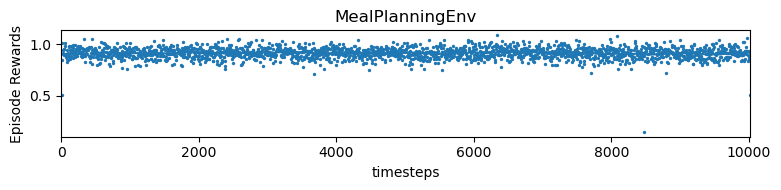

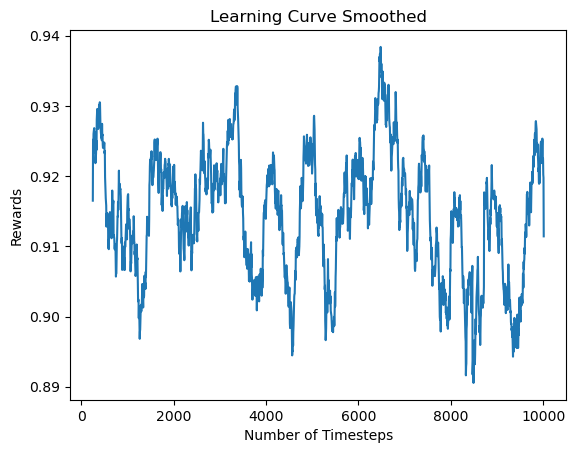

In [3]:
from stable_baselines3 import PPO, DQN
import numpy as np
import pandas as pd
from heuristic_environment import MealPlanningEnv
from dietkit import load_ingredient, load_menu, load_diet
import matplotlib.pyplot as plt

import os 
import time
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()
    

log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=True)

all_ingredients = load_ingredient(sample_language='eng')
meal_dict = load_menu(
    ingredients=all_ingredients,
    sample_language='eng'
)
example_mealplans = load_diet(
    menus=meal_dict, 
    num_loads=100, 
    sample_language='eng', 
    sample_name='ML'
)

# downsample meals to size num_possible_meals
num_possible_meals = len(meal_dict.keys())
old_meal_dict = meal_dict
keys_to_keep = np.random.choice(list(meal_dict.keys()), size=num_possible_meals, replace=False)
meal_dict = {}
for key in keys_to_keep:
    meal_dict[key] = old_meal_dict[key]

possible_meals = np.array(list(meal_dict.keys()))
meal_categories = np.array([meal.category if isinstance(meal.category, str) else meal.category[0] for meal in meal_dict.values()])
nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)

num_meals = 5
env = MealPlanningEnv(
  possible_meals=possible_meals, 
  meal_categories=meal_categories,
  nutrition_data=nutrition_data, 
  num_meals=num_meals
)

env = Monitor(env, log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

model = DQN("MultiInputPolicy", env, verbose=1)
obs = env.reset()
for i in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
env.render()

model.learn(total_timesteps=10000, callback=callback)

obs = env.reset()
action, _ = model.predict(obs)
for _ in range(num_meals):
  obs, rewards, done, info = env.step(action)
  action, _ = model.predict(obs)
env.render()

results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "MealPlanningEnv"
)

plot_results(log_dir)

In [2]:
obs = env.reset()
action, _ = model.predict(obs)
for _ in range(num_meals):
  obs, rewards, done, info = env.step(action)
  action, _ = model.predict(obs)
env.render()
num_unique_meals_chosen = len(np.unique(env.meal_history))
print(f'Possible meals: {env.possible_meals}')
print(f'Unique meals chosen: {num_unique_meals_chosen}')

Step: 21
Chosen Meal: Petite gimbap (rice roll)
Chosen Meal Category: Combo meal rice
Meal History: ['Petite gimbap (rice roll)' 'Petite gimbap (rice roll)'
 'Petite gimbap (rice roll)' 'Petite gimbap (rice roll)'
 'Petite gimbap (rice roll)' 'Braised pollack'
 'Steamed aubergine with marinade sauce'
 'Steamed aubergine with marinade sauce'
 'Steamed aubergine with marinade sauce' 'Petite gimbap (rice roll)'
 'Steamed aubergine with marinade sauce'
 'Stir-fried oyster mushroom and perilla seeds'
 'Stir-fried oyster mushroom and perilla seeds'
 'Steamed aubergine with marinade sauce' 'S croissant (30g)'
 'S croissant (30g)' 'S croissant (30g)' 'S croissant (30g)'
 'Petite gimbap (rice roll)' 'Petite gimbap (rice roll)'
 'Petite gimbap (rice roll)']
Category History: ['Combo meal rice' 'Combo meal rice' 'Combo meal rice' 'Combo meal rice'
 'Combo meal rice' 'Braised' 'Steamed' 'Steamed' 'Steamed'
 'Combo meal rice' 'Steamed' 'Stir-fried' 'Stir-fried' 'Steamed'
 'Grains (snack)' 'Grains (

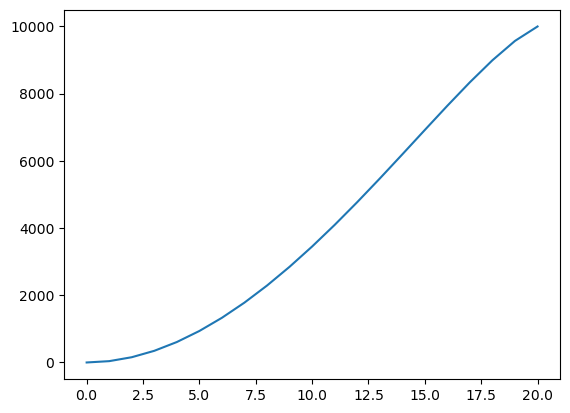

In [5]:
from collections import Counter
from scipy import stats

def entropy_of_sequence(input_list):
    # get counts
    count_data = list(Counter(input_list).values())
    
    # get entropy from counts
    entropy = stats.entropy(count_data)  
    
    return entropy

sequence = np.ones(shape=num_meals)
reward_list = []
max_entropy = entropy_of_sequence(list(range(num_meals)))
for num_unique in range(num_meals):
    sequence_to_test = list(range(num_unique)) + [-1] * (num_meals - num_unique)
    entropy_fraction = entropy_of_sequence(sequence_to_test) / max_entropy
    reward = (100 * entropy_fraction)**2
    reward_list.append(reward)
plt.plot(reward_list)

In [2]:
from stable_baselines3 import PPO, DQN
import numpy as np
import pandas as pd
from heuristic_environment import MealPlanningEnv
from dietkit import load_ingredient, load_menu, load_diet
import matplotlib.pyplot as plt

import os 
import time
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

all_ingredients = load_ingredient(sample_language='eng')
meal_dict = load_menu(
    ingredients=all_ingredients,
    sample_language='eng'
)
# example_mealplans = load_diet(
#     menus=meal_dict, 
#     num_loads=100, 
#     sample_language='eng', 
#     sample_name='ML'
# )

# downsample meals to size num_possible_meals
num_possible_meals = len(meal_dict.keys())
old_meal_dict = meal_dict
keys_to_keep = np.random.choice(list(meal_dict.keys()), size=num_possible_meals, replace=False)
meal_dict = {}
for key in keys_to_keep:
    meal_dict[key] = old_meal_dict[key]

possible_meals = np.array(list(meal_dict.keys()))
meal_categories = np.array([meal.category if isinstance(meal.category, str) else meal.category[0] for meal in meal_dict.values()])
nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)

env = MealPlanningEnv(
  possible_meals=possible_meals, 
  meal_categories=meal_categories,
  nutrition_data=nutrition_data, 
  num_meals=num_meals
)

env.reset()
for action in range(21):
    env.step(action)
env.render()

2023-04-22 20:41:47.940821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'num_meals' is not defined

In [11]:
nutrition_data.columns

Index(['Energy', 'Protein', 'Fat', 'Carbohydrate', 'Total Dietary', 'Calcium',
       'Iron', 'Sodium', 'Vitamin A', 'Vitamin B1 (Thiamine)',
       'Vitamin B2 (Rivoflavin)', 'Vitamin C', 'Linoleic Acid',
       'Alpha-Linolenic Acid'],
      dtype='object')